Starting grid search for Logistic Regression...
Best parameters for Logistic Regression: {'fit_intercept': True}
Best cross-validation score (MSE): -0.0
Starting grid search for SVC...
Best parameters for SVC: {'C': 0.1, 'kernel': 'linear'}
Best cross-validation score (MSE): -0.0
Starting grid search for Random Forest...
Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 50}
Best cross-validation score (MSE): -0.0
Starting grid search for KNN...
Best parameters for KNN: {'n_neighbors': 3, 'weights': 'uniform'}
Best cross-validation score (MSE): -0.0
Starting grid search for ANN...
Best parameters for ANN: {'activation': 'tanh', 'hidden_layer_sizes': (100,)}
Best cross-validation score (MSE): 0.02256375263521419
Starting grid search for XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.01, 'n_estimators': 50}
Best cross-validation score (MSE): -0.0
Logistic Regression:
  Runtime: 0.003210 seconds
  Training MSE: 0.000000

SVC:
  Runtime: 0.001125 seconds
  

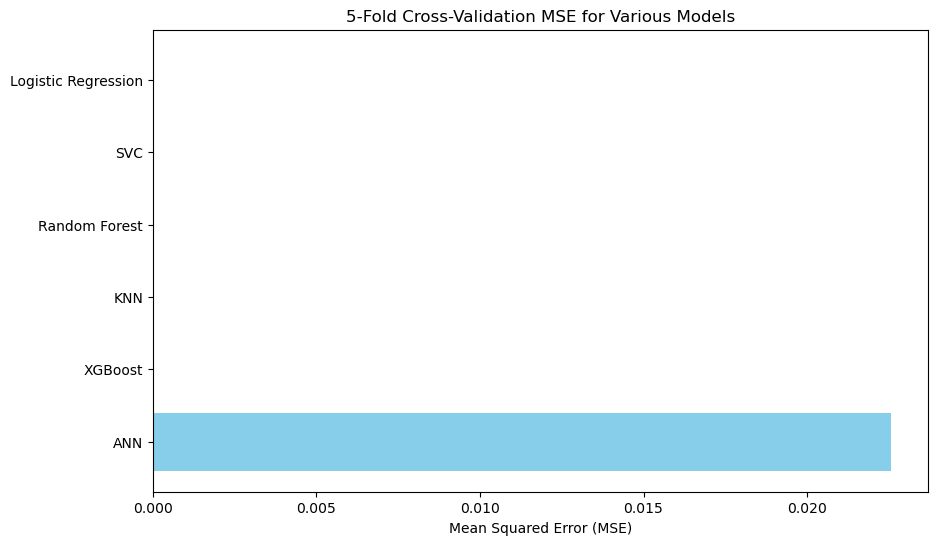

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score


# Load the dataset
file_path = '/Users/victoriali/Desktop/student-mat.csv'
data = pd.read_csv(file_path, delimiter=';')

# Label encoding for all categorical columns
label_encoders = {}
for column in data.columns:
    if data[column].dtype == 'object':
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le

# Binary classification problem 2: Predicting school (already binary, just encode directly)
data['school_binary'] = (data['school'] == 'GP').astype(int)

# Drop the 'school' column since we've now encoded it as 'school_binary'
data = data.drop('school', axis=1)

# Select numerical data for PCA
numerical_data = data.select_dtypes(include=[float, int])

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data)

# Apply PCA to reduce the number of features to half
pca = PCA(n_components=int(numerical_data.shape[1] / 2))
principal_components = pca.fit_transform(scaled_data)

# Add principal components to the data
for i in range(principal_components.shape[1]):
    data[f'PC{i+1}'] = principal_components[:, i]

# Now your features include PCA components
X = data.drop('school_binary', axis=1)
y = data['school_binary']

# Split dataset into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models for cross-validation
models = {
    'Logistic Regression': LogisticRegression(),
    'SVC': SVC(probability=True),  # SVC for classification with probability enabled
    'Random Forest': RandomForestClassifier(random_state=42),  # Classifier, not Regressor
    'KNN': KNeighborsClassifier(),
    'ANN': MLPClassifier(max_iter=1000, random_state=42),
    'XGBoost': GradientBoostingClassifier(random_state=42)  # Classifier, not Regressor
}

# Define hyperparameter grids for each model
param_grid_lr = {'fit_intercept': [True, False]}
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
param_grid_rf = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}
param_grid_knn = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
param_grid_ann = {'hidden_layer_sizes': [(50,), (100,)], 'activation': ['tanh', 'relu']}
param_grid_xgb = {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2]}

# Perform grid search for each model
best_models = {}
for model_name, model, param_grid in zip(
    ['Logistic Regression', 'SVC', 'Random Forest', 'KNN', 'ANN', 'XGBoost'],
    [LinearRegression(), SVR(), RandomForestRegressor(random_state=42), KNeighborsRegressor(),
     MLPRegressor(max_iter=1000, random_state=42), GradientBoostingRegressor(random_state=42)],
    [param_grid_lr, param_grid_svm, param_grid_rf, param_grid_knn, param_grid_ann, param_grid_xgb]
):
    print(f"Starting grid search for {model_name}...")
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score (MSE): {-grid_search.best_score_}")

# Train models and evaluate performance
performance_and_runtime = {}
for name, model in best_models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    runtime = end_time - start_time
    training_mse = mean_squared_error(y_train, model.predict(X_train))
    
    performance_and_runtime[name] = {
        'Runtime (s)': runtime,
        'Training MSE': training_mse
    }

# Display the runtime and training MSE for each model
for model_name, metrics in performance_and_runtime.items():
    print(f"{model_name}:")
    print(f"  Runtime: {metrics['Runtime (s)']:.6f} seconds")
    print(f"  Training MSE: {metrics['Training MSE']:.6f}\n")

# Perform 5-fold cross-validation and compute MSE for each trained model
cv_mse = {}
for name, model in best_models.items():
    mse_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_mse[name] = -mse_scores.mean()

# Convert negative MSE to positive for visualization and sort values for the plot
sorted_mse = {k: v for k, v in sorted(cv_mse.items(), key=lambda item: item[1])}

# Create a horizontal bar chart for visualization
plt.figure(figsize=(10, 6))
plt.barh(list(sorted_mse.keys()), list(sorted_mse.values()), color='skyblue')
plt.xlabel('Mean Squared Error (MSE)')
plt.title('5-Fold Cross-Validation MSE for Various Models')
plt.gca().invert_yaxis()
plt.show()

# Train models and evaluate performance
performance_and_runtime = {}
for name, model in best_models.items():
    start_time = time.time()
    model.fit(X_train, y_train)  # Train the model
    end_time = time.time()
    runtime = end_time - start_time
    
    # Predict using the trained model
    if hasattr(model, "predict_proba"):
        # Use the second column because it corresponds to the probabilities of the positive class
        y_pred = model.predict_proba(X_train)[:, 1] > 0.5
    else:
        y_pred = model.predict(X_train)
    
    # Calculate accuracy assuming y_pred is binary
    training_accuracy = accuracy_score(y_train, y_pred)
    
    performance_and_runtime[name] = {
        'Runtime (s)': runtime,
        'Training Accuracy': training_accuracy
    }

# Display the runtime and training accuracy for each model
for model_name, metrics in performance_and_runtime.items():
    print(f"{model_name}:")
    print(f"  Runtime: {metrics['Runtime (s)']:.6f} seconds")
    print(f"  Training Accuracy: {metrics['Training Accuracy']:.2%}\n")